<a href="https://colab.research.google.com/github/Toan-Nguyen26/dream_PGE/blob/main/mode_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model training

In [1]:
RUNTIME = 'msi'

In [34]:
import zipfile

# Replace 'your_folder.zip' with your actual filename
with zipfile.ZipFile('s3.msi.umn.edu.zip', 'r') as zip_ref:
    zip_ref.extractall('.')  # This extracts to the current directory

### Install external packages

In [4]:
%%bash -s "$RUNTIME"
if [[ "$1" == "colab" ]]; then
  pip install -U tensorflow-addons
  pip install -U session_info
  pip install -U biopython
else
  pip install tensorflow
  pip install tensorflow_probability
  pip install session_info
  pip install biopython
  pip install sklearn
  pip install matplotlib
  # pip install tensorflow_io
fi

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Load Python packages

In [9]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from scipy import stats
import session_info
# import tensorflow_probability as tfp
import pdb
from sklearn.metrics import r2_score
import shutil
import pandas as pd
import re
import os
from Bio.Seq import Seq
import gc
import matplotlib.pyplot as plt
import datetime
import socket
import time
import json
from collections import OrderedDict
import random as python_random

In [10]:
if RUNTIME == 'colab':
  from google.colab import drive

### TensorFlow setup

In [11]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print('Physical GPUs: {}'.format(len(gpus)))
print('Logical GPUs: {}'.format(len(logical_gpus)))

Physical GPUs: 1
Logical GPUs: 1


In [12]:
socket.gethostname()

'0dfdab3d41bd'

## Parameters

In [13]:
ARGS = {
  'model_id' : 'm20220727e',
  'global_seed' : 123,
  'shuffle_size' : 1000,
  'max_width' : 100,
  'head_len' : 17,
  'tail_len' : 13,
  'pct_ds' : 1, # % of total data for training/testing,
  'train_split' : 0.95,
  'alphabets' : {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3, 'N' : 4, 'M' : 5},
  'learning_rate' : 0.001,
  'initial_epoch': 0,
  'epochs' : 20,
  'batch_size' : 512,
  'dropout_rate' : 0.1,
  'kmer': 10,
  'strides' : 1,
  'embedding_dim' : 512,
  'num_heads' : 8,
  'ff_mult' : 4,
  'num_projectors' : 32,
  'n_blocks_regressor' : 4,
  'warmup_steps' : 12500, # ~ 1 epoch
  'mask_ratio' : 0.05,
  'remote_sample_submission_file' : 'https://raw.githubusercontent.com/de-Boer-Lab/DREAM-2022/main/sample_submission.json',
}
if RUNTIME == 'msi':
  ARGS['remote_data_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/training_data/pct_ds=' + str(ARGS['pct_ds']) + '/'
  ARGS['local_data_dir'] = re.sub('https://', './', ARGS['remote_data_dir'])
  ARGS['remote_checkpoint_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/notebooks_msi/' + ARGS['model_id'] + '/tf_ckpts/'
  ARGS['remote_log_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/notebooks_msi/' + ARGS['model_id'] + '/log/'
  ARGS['local_checkpoint_dir'] = re.sub('https://', './', ARGS['remote_checkpoint_dir'])
  ARGS['local_log_dir'] = re.sub('https://', './', ARGS['remote_log_dir'])
  ARGS['remote_test_data'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/test_sequences.txt.gz'
  ARGS['local_test_data'] = re.sub('https://', './', ARGS['remote_test_data'])
  ARGS['local_sample_submission_file'] = re.sub('https://', './', ARGS['remote_sample_submission_file'])
  ARGS['remote_prediction_file'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/' + ARGS['model_id'] + '/pred.json'
  ARGS['local_prediction_file'] = re.sub('https://', './', ARGS['remote_prediction_file'])
  ARGS['s3_prediction_file'] = re.sub('https://s3.msi.umn.edu', 's3://', ARGS['remote_prediction_file'])
  ARGS['remote_prediction_tsv_file'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/' + ARGS['model_id'] + '/pred.tsv'
  ARGS['local_prediction_tsv_file'] = re.sub('https://', './', ARGS['remote_prediction_tsv_file'])
  ARGS['s3_prediction_tsv_file'] = re.sub('https://s3.msi.umn.edu', 's3://', ARGS['remote_prediction_tsv_file'])
else:
  ARGS['local_data_dir'] = '/content/drive/MyDrive/training_data/pct_ds=' + str(ARGS['pct_ds']) + '/'
  ARGS['local_checkpoint_dir'] = '/content/drive/MyDrive/' + ARGS['model_id'] + '/tf_ckpts/'
  ARGS['local_log_dir'] = '/content/drive/MyDrive/' + ARGS['model_id'] + '/log/'

### Set seeds

In [14]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(ARGS['global_seed'])

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
tf.random.set_seed(ARGS['global_seed'])

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
python_random.seed(ARGS['global_seed'])

## Functions

In [15]:
mse_loss = keras.losses.MeanSquaredError(reduction = 'none')

In [16]:
scc_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

### pearson_r

https://www.tutorialexample.com/implement-pearson-correlation-coefficient-loss-in-tensorflow-tensorflow-tutorial/

In [17]:
def pearson_r(x, y):

  mx = tf.reduce_mean(x, axis = 0, keepdims = True)
  my = tf.reduce_mean(y, axis = 0, keepdims = True)
  xm = x - mx
  ym = y - my
  t1_norm = tf.nn.l2_normalize(xm, axis = 0)
  t2_norm = tf.nn.l2_normalize(ym, axis = 0)
  return tf.reduce_sum(tf.multiply(t1_norm, t2_norm))

In [18]:
x = np.random.rand(100)
y = np.random.rand(100)
print('pearson r (stats.pearsonr): {}'.format(stats.pearsonr(x, y)[0]))
print('pearson r (pearson_r): {}'.format(pearson_r(tf.expand_dims(x, 1), tf.expand_dims(y, 1))))

pearson r (stats.pearsonr): -0.09270195576139686
pearson r (pearson_r): -0.09270195576139688


### GLULayer

In [19]:
class GLULayer(layers.Layer):
  def __init__(self, dim):
    super(GLULayer, self).__init__()
    self.dim = dim

  def call(self, x):
    out, gate = tf.split(x, 2, axis = self.dim)
    return out * tf.sigmoid(gate)

In [20]:
layer = GLULayer(dim = 2)
x = tf.random.uniform([3, 10, 6])
layer(x).shape

TensorShape([3, 10, 3])

### SwiGLU

In [21]:
class SwiGLULayer(layers.Layer):
  def __init__(self, dim):
    super(SwiGLULayer, self).__init__()
    self.dim = dim
    self.swish = layers.Activation('swish')

  def call(self, x):
    out, gate = tf.split(x, 2, axis = self.dim)
    return out * self.swish(gate)

In [22]:
layer = GLULayer(dim = 2)
x = tf.random.uniform([3, 10, 6])
layer(x).shape

TensorShape([3, 10, 3])

### FeedForwardSwiGLU

In [23]:
class FeedForwardSwiGLU(layers.Layer):
  def __init__(self, embedding_dim, mult=4, rate = 0.0, use_bias = False):
    super(FeedForwardSwiGLU, self).__init__()
    self.net = tf.keras.Sequential(
      [
        layers.LayerNormalization(epsilon = 1e-6),
        layers.Dense(embedding_dim * mult, use_bias = use_bias),
        SwiGLULayer(dim = 2),
        layers.Dropout(rate),
        layers.Dense(embedding_dim, use_bias = use_bias),
        layers.Dropout(rate),
      ]
    )

  def call(self, inputs):
    return self.net(inputs)

In [24]:
ffn = FeedForwardSwiGLU(embedding_dim = 5, mult = 4)
x = tf.random.uniform([3, 10, 5])
print(ffn(x).shape)

(3, 10, 5)


### CustomSchedule

In [25]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [26]:
d_model = 128
learning_rate = CustomSchedule(d_model)
temp_learning_rate_schedule = CustomSchedule(d_model, warmup_steps=4000)

Text(0.5, 0, 'Train Step')

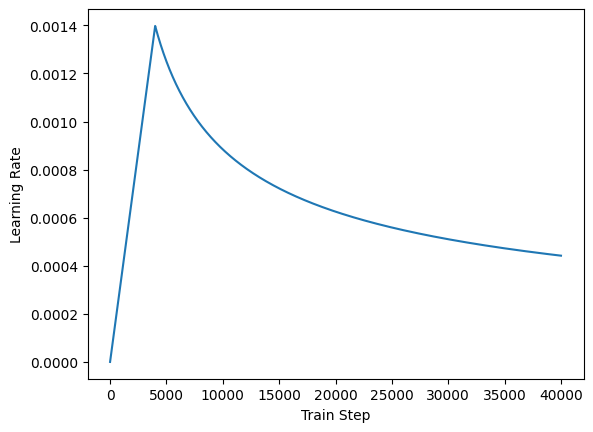

In [27]:
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### ConformerSASwiGLULayer

In [28]:
class ConformerSASwiGLULayer(layers.Layer):
  def __init__(self, embedding_dim,  ff_mult = 4, kernel_size = 15, rate = 0.2, num_heads = 4, use_bias = False):
    super(ConformerSASwiGLULayer, self).__init__()
    self.ff1 = FeedForwardSwiGLU(embedding_dim = embedding_dim, mult = ff_mult, rate = rate, use_bias = use_bias)
    self.conv = tf.keras.Sequential([
      layers.LayerNormalization(epsilon = 1e-6),
      layers.SeparableConv1D(filters = embedding_dim, kernel_size = kernel_size, padding = 'same', activation = 'relu'),
      layers.Dropout(rate),
    ])
    self.layernorm = layers.LayerNormalization(epsilon = 1e-6)
    self.attn = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embedding_dim)
    self.ff2 = FeedForwardSwiGLU(embedding_dim = embedding_dim, mult = ff_mult, rate = rate, use_bias = use_bias)

  def call(self, x):
    x = tf.cast(x, dtype = tf.dtypes.float32)
    x = x + 0.5 * self.ff1(x)
    x = x + self.conv(x)
    x = self.layernorm(x)
    x = x + self.attn(x, x)
    x = x + 0.5 * self.ff2(x)
    return x

In [29]:
layer = ConformerSASwiGLULayer(embedding_dim = 14)
x = tf.random.uniform([3, 10, 14])
print(layer(x).shape)

(3, 10, 14)


### SequenceMaskLayer

In [30]:
class SequenceMaskLayer(layers.Layer):
  def __init__(self, n_positions, ratio = 0.2):
    super(SequenceMaskLayer, self).__init__()
    self.ratio = ratio
    self.n_positions = n_positions
    self.N = 4
    self.M = 5

  def call(self, x):

    if self.ratio > 0:
      m = tf.random.uniform(tf.shape(x)) < self.ratio
      m = tf.cast(m, dtype = tf.uint8)
      is_valid = tf.cast(tf.math.not_equal(x, self.N), tf.uint8)
      m = m * is_valid
      x0 = tf.ones(tf.shape(x), dtype = tf.uint8) * self.M

      x = m * x0 + (1 - m) * x
      m = tf.cast(m, dtype = tf.float32)
    else:
      m = tf.zeros(tf.shape(x))

    return x, m

In [31]:
layer = SequenceMaskLayer(n_positions = 20, ratio = 0.2)
x = tf.random.uniform([3, 20], maxval = 5)
x = tf.cast(x, tf.uint8)
print(x)
x, m = layer(x)
print(x)
print(m)

tf.Tensor(
[[4 3 1 0 1 1 3 2 3 0 1 1 1 3 2 1 2 4 0 4]
 [0 0 1 4 2 4 0 2 1 4 0 1 1 4 4 0 1 2 1 3]
 [2 1 4 1 0 0 0 3 2 2 4 0 3 0 3 0 3 4 1 0]], shape=(3, 20), dtype=uint8)
tf.Tensor(
[[4 3 5 0 1 5 3 5 5 0 5 1 5 3 2 5 5 4 0 4]
 [0 5 1 4 5 4 0 2 5 4 5 1 1 4 4 0 1 2 1 3]
 [2 1 4 1 0 0 0 3 2 2 4 0 3 0 3 5 3 4 5 0]], shape=(3, 20), dtype=uint8)
tf.Tensor(
[[0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]], shape=(3, 20), dtype=float32)


## Read data

In [32]:
input_dim = int(6) # A,C,G,T,N,M
#input_dim = int(5) # A,C,G,T,N
n_positions = ARGS['max_width'] * 2

The tfdataset was prepraed by this notebook: https://github.com/ikwak2/dream_PGE/blob/main/notebooks/prepare_tfdatasets.ipynb

In [35]:
ds = tf.data.experimental.load(ARGS['local_data_dir'])

In [36]:
!ls

__MACOSX  s3.msi.umn.edu  s3.msi.umn.edu.zip  sample_data


In [37]:
n = int(ds.cardinality())
n_train = int(n * ARGS['train_split'])
print('downsampled dataset size: %d' % (n))
print('training dataset size: %d' % (n_train))

downsampled dataset size: 6737568
training dataset size: 6400689


In [38]:
ds = ds.shuffle(ARGS['shuffle_size'], seed = 1)

In [39]:
train_ds = ds.take(n_train)
test_ds = ds.skip(n_train)
print('# training samples: %d' % (train_ds.cardinality()))
print('# test samples: %d' % (test_ds.cardinality()))

# training samples: 6400689
# test samples: 336879


In [40]:
train_ds = train_ds.batch(ARGS['batch_size'])
test_ds = test_ds.batch(ARGS['batch_size'])

In [41]:
train_ds.element_spec

{'expression': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'base': TensorSpec(shape=(None, 200), dtype=tf.uint8, name=None),
 'seq': TensorSpec(shape=(None, 200), dtype=tf.uint8, name=None)}

## The regressor

In [42]:
class Regressor(keras.Model):
  def __init__(self, n_positions, kmer = 3, embedding_dim = 32, input_dim = 5, n_blocks = 4, kernel_size =15, rate = 0.2, strides = 2, ratio = 0.2, num_heads = 4, ff_mult = 4, use_bias = False, num_projectors = 8):
    super(Regressor, self).__init__()
    self.n_positions = int(n_positions / strides)
    self.input_dim = input_dim
    self.kmer = kmer
    self.strides = strides
    self.num_projectors = num_projectors
    self.n_blocks = n_blocks
    self.masking = SequenceMaskLayer(n_positions = n_positions, ratio = ratio)
    self.pos_embedding = layers.Embedding(self.n_positions, embedding_dim)
    self.strand_embedding = layers.Embedding(2, embedding_dim) # plus/minus strands
    self.expression_embedding = layers.Dense(embedding_dim)
    self.kmer_dense = layers.Dense(embedding_dim)
    self.blocks = keras.Sequential([ConformerSASwiGLULayer(embedding_dim = embedding_dim, kernel_size = kernel_size, rate = rate, num_heads = num_heads) for _ in range(n_blocks)])
    self.dropout = layers.Dropout(rate)
    self.expression_dense = layers.Dense(1)
    self.nucleotide_dense = layers.Dense(input_dim)

  def call(self, x):

    batch_size = tf.shape(x['seq'])[0]

    x = tf.one_hot(x['seq'], self.input_dim)

    x = tf.expand_dims(x, 2)
    x = tf.image.extract_patches(x, sizes = [1, self.kmer, 1, 1], strides = [1, self.strides, 1, 1], rates = [1, 1, 1, 1], padding = 'SAME')
    x = tf.squeeze(x, 2)

    x = self.kmer_dense(x)

    pos = tf.range(start=0, limit=self.n_positions, delta=1)
    pos = tf.expand_dims(pos, 0)
    pos = self.pos_embedding(pos)

    strand = tf.repeat([0,1], repeats = int(self.n_positions / 2))
    strand = tf.expand_dims(strand, 0)
    strand = self.strand_embedding(strand)

    x = x + pos + strand

    expression = tf.zeros((batch_size, self.num_projectors, 1), dtype = tf.float32)
    expression = self.expression_embedding(expression)

    x = tf.concat([expression, x], axis = 1)
    x = self.blocks(x)

    expression = x[:,:self.num_projectors,:]
    x = x[:, -self.n_positions:, :]

    expression = self.dropout(expression)
    expression = self.expression_dense(expression)
    expression = tf.reduce_mean(expression, 1)

    x = self.nucleotide_dense(x)

    return expression, x

  def train_step(self, batch):

    seq, mask = self.masking(batch['seq'])

    with tf.GradientTape() as tape:
      expression, seq_pred = self({'seq' : seq})
      loss_expression = mse_loss(batch['expression'], expression)
      loss_expression = tf.reduce_mean(loss_expression)
      loss_seq = mask * scc_loss(batch['seq'], seq_pred)
      loss_seq = tf.reduce_sum(loss_seq) / (tf.reduce_sum(mask) + 1)
      loss = loss_expression + loss_seq

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.compiled_metrics.update_state(batch['expression'], expression)
    res = {'loss' : loss, 'loss_seq' : loss_seq, 'loss_expression' : loss_expression}
    res.update({m.name: m.result() for m in self.metrics})
    return res

def test_step(self, batch):
    # During validation, we only care about the expression output
    expression, _ = self(batch)

    # Update metrics for the expression output only
    self.compiled_metrics.update_state(batch['expression'], expression)

    # Return metrics
    return {m.name: m.result() for m in self.metrics}

In [43]:
model = Regressor(embedding_dim = 12, n_positions = 120, kernel_size = 3, strides = 1, num_projectors = ARGS['num_projectors'])
x = tf.random.uniform((3, 120), maxval = 5)
x = tf.cast(x, dtype = tf.uint8)
expression_pred, x = model({'seq' : x})
print(expression_pred.shape)
print(x.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'regressor', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


(3, 1)
(3, 120, 5)


In [44]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.experimental.CentralStorageStrategy()
#strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

In [45]:
with strategy.scope():
  model = Regressor(
    n_positions = n_positions,
    embedding_dim = ARGS['embedding_dim'],
    n_blocks = ARGS['n_blocks_regressor'],
    kmer = ARGS['kmer'],
    input_dim = input_dim,
    strides = ARGS['strides'],
    ratio = ARGS['mask_ratio'],
    num_heads = ARGS['num_heads'],
    rate = ARGS['dropout_rate'],
    num_projectors = ARGS['num_projectors'],
  )

In [47]:
learning_rate = CustomSchedule(ARGS['embedding_dim'], warmup_steps = ARGS['warmup_steps'])
optimizer = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1 = 0.9,
    beta_2 = 0.98,
    epsilon = 1e-9,
    global_clipnorm = 1.0
)

In [60]:
# Define the metrics separately from compile
expression_metric = pearson_r  # For the first output
seq_metric = None  # For the second output (no metric)

# Then compile with a list of metrics
model.compile(
  optimizer=optimizer,
  metrics=[expression_metric, seq_metric]
)

In [49]:
if ARGS['train_split'] < 1:
  monitor = 'val_pearson_r'
else:
  monitor = 'pearson_r'

In [52]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath = ARGS['local_checkpoint_dir'] + 'model.weights.h5',  # Add filename with proper extension
  save_weights_only = True,
  monitor = monitor,
  mode='max',
  save_best_only = True,
  save_freq = 'epoch',
)

## Model fitting

### Epoch 1

initial epoch: 1

In [61]:
if ARGS['train_split'] < 1:
  model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = ARGS['epochs'],
    callbacks = [model_checkpoint_callback],
    initial_epoch = 1 - 1,
  )
else:
  model.fit(
    train_ds,
    epochs = ARGS['epochs'],
    callbacks = [model_checkpoint_callback],
    initial_epoch = 1 - 1,
  )


ValueError: Tried to convert 'input' to a tensor and failed. Error: None values not supported.

## Read testing data

In [ ]:
os.system('wget -cx ' + ARGS['remote_test_data'])

--2022-08-07 17:29:51--  https://s3.msi.umn.edu/gongx030/projects/dream_PGE/test_sequences.txt.gz
Resolving s3.msi.umn.edu (s3.msi.umn.edu)... 128.101.189.144
Connecting to s3.msi.umn.edu (s3.msi.umn.edu)|128.101.189.144|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



0

In [ ]:
df = pd.read_csv(ARGS['local_test_data'], compression = 'gzip', sep = '\t', header = None)
df.columns = ['dna', 'expression']
df['dna'] = df['dna'].astype('string')
df['dna0'] = df['dna']
print('test dataset size: %d' % len(df))

test dataset size: 71103


min len: 110
max len: 110


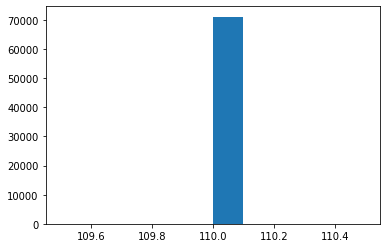

In [ ]:
df['len'] = df['dna'].str.len()
plt.hist(df['len'])
print('min len: {}'.format(df['len'].min()))
print('max len: {}'.format(df['len'].max()))

In [ ]:
print('number of unique sequences in the first {} positions: {}'.format(ARGS['head_len'], len(df['dna'].str[:ARGS['head_len']].unique())))
print('number of unique sequences in the last {} positions: {}'.format(ARGS['tail_len'], len(df['dna'].str[-ARGS['tail_len']:].unique())))

number of unique sequences in the first 17 positions: 1
number of unique sequences in the last 13 positions: 1


In [ ]:
df['dna'] = df['dna'].str[ARGS['head_len']:]
df['dna'] = df['dna'].str[:-ARGS['tail_len']]

min len: 80
max len: 80


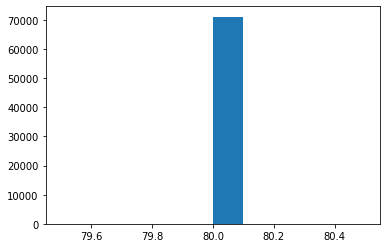

In [ ]:
df['len'] = df['dna'].str.len()
plt.hist(df['len'])
print('min len: {}'.format(df['len'].min()))
print('max len: {}'.format(df['len'].max()))

In [ ]:
assert all(df['len'] <= ARGS['max_width'])

In [ ]:
df['dna'] = df['dna'].str.pad(width = ARGS['max_width'], side = 'both', fillchar = 'N')
df['dna'] = df['dna'] + df['dna'].apply(lambda x: str(Seq(x).reverse_complement())).astype('string')

In [ ]:
#input_dim = int(5) # A,C,G,T,N
input_dim = int(6) # A,C,G,T,N,M
n_positions = ARGS['max_width'] * 2

In [ ]:
n_positions = int(ARGS['max_width'] * 2)
print('# positions=%d' % (n_positions))

# positions=200


In [ ]:
dna = np.empty((0, n_positions), np.uint8)
for x in np.array_split(df['dna'], 10): # split data into chunks
  y = np.array(x.apply(list))
  y = np.vstack(y)
  y = np.vectorize(ARGS['alphabets'].get)(y)
  y = y.astype(np.uint8)
  print(y.shape)
  dna = np.append(dna, y, axis = 0)

(7111, 200)
(7111, 200)
(7111, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)


In [ ]:
base = np.zeros(dna.shape, dtype = np.uint8)
base[dna == 4] = 0 #
base[(dna == 0) | (dna == 2)] = 1 # A/G
base[(dna == 1) | (dna == 3)] = 2 # C/T

In [ ]:
ds = tf.data.Dataset.from_tensor_slices({
  'seq' : dna,
  'expression' : tf.zeros([len(df)]),
  'base' : base,
})
ds.element_spec

{'seq': TensorSpec(shape=(200,), dtype=tf.uint8, name=None),
 'expression': TensorSpec(shape=(), dtype=tf.float32, name=None),
 'base': TensorSpec(shape=(200,), dtype=tf.uint8, name=None)}

## Prediction

In [ ]:
model.load_weights(ARGS['local_checkpoint_dir'])

In [ ]:
expression = []
pbar = keras.utils.Progbar(len(ds.batch(ARGS['batch_size'])))
for step, batch in enumerate(ds.batch(ARGS['batch_size'])):
  pbar.update(step)
  expression_pred, _ = model(batch)
  expression.append(expression_pred)
expression = tf.concat(expression, axis = 0)

138/139 [============================>.] - ETA: 0s

In [ ]:
df['expression'] = expression.numpy()

In [ ]:
print('mean predicted expression: {}'.format(df['expression'].mean()))
print('std predicted expression: {}'.format(df['expression'].std()))

mean predicted expression: 0.29278337955474854
std predicted expression: 1.0623327493667603


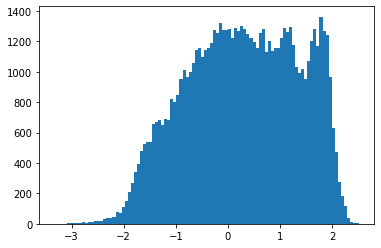

In [ ]:
p = plt.hist(df['expression'], bins = 100)

## Prepare submission file

In [ ]:
model.summary()

Model: "regressor_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence_mask_layer_2 (Seque multiple                  0 (unused)
_________________________________________________________________
embedding_2 (Embedding)      multiple                  102400    
_________________________________________________________________
embedding_3 (Embedding)      multiple                  1024      
_________________________________________________________________
dense_26 (Dense)             multiple                  1024      
_________________________________________________________________
dense_27 (Dense)             multiple                  31232     
_________________________________________________________________
sequential_29 (Sequential)   (None, 232, 512)          47286272  
_________________________________________________________________
dropout_49 (Dropout)         multiple                  

Modified from https://github.com/de-Boer-Lab/DREAM-2022/blob/main/How%20to%20submit%20predictions%20to%20the%20public%20leaderboard.pdf

In [ ]:
os.system('wget -cx ' + ARGS['remote_sample_submission_file'])

--2022-08-07 17:32:22--  https://raw.githubusercontent.com/de-Boer-Lab/DREAM-2022/main/sample_submission.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



0

In [ ]:
with open(ARGS['local_sample_submission_file'], 'r') as f:
  ground = json.load(f)

In [ ]:
indices = np.array([int(indice) for indice in list(ground.keys())])

In [ ]:
PRED_DATA = OrderedDict()
Y_Pred = df['expression'].to_numpy()

In [ ]:
for i in indices:
  PRED_DATA[str(i)] = float(Y_Pred[i])

In [ ]:
local_prediction_dir = re.sub('(.+/)..+', '\\1', ARGS['local_prediction_file'])
if not os.path.exists(local_prediction_dir):
  os.makedirs(local_prediction_dir)
  print('creating {}'.format(local_prediction_dir))

In [ ]:
with open(ARGS['local_prediction_file'], 'w') as f:
  json.dump(PRED_DATA, f)
print('writing {}'.format(ARGS['local_prediction_file']))

writing ./s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/m20220727e/pred.json


Only if the notebook runs on MSI, otherwise, ignore this cell.

In [ ]:
!s3cmd sync {ARGS['local_prediction_file']} {ARGS['s3_prediction_file']}
!s3cmd setacl -P {ARGS['s3_prediction_file']}

In [ ]:
print('prediction file: {}'.format(ARGS['remote_prediction_file']))

prediction file: https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/m20220727e/pred.json


In [ ]:
df[['dna0', 'expression']].to_csv(ARGS['local_prediction_tsv_file'], header = False, sep = '\t', index = False)

In [ ]:
!s3cmd sync {ARGS['local_prediction_tsv_file']} {ARGS['s3_prediction_tsv_file']}
!s3cmd setacl -P {ARGS['s3_prediction_tsv_file']}

In [ ]:
print('prediction file(tsv): {}'.format(ARGS['remote_prediction_tsv_file']))

prediction file(tsv): https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/m20220727e/pred.tsv


# SessionInfo

In [ ]:
session_info.show()